In [27]:
import sys
sys.path.append("..")
sys.path.append("../datasets")
import torch
import torch
from torch.nn import functional as F

from devinterp.optim import SGLD
from devinterp.slt.sampler import estimate_learning_coeff_with_summary
from devinterp.utils import plot_trace, default_nbeta

from rasp_models.fractok import check_fractok
from tracr.haiku_to_pytorch import haiku_to_pytorch


from datasets.dataloaders import makeFractokDataLoader
from torchinfo import summary

In [28]:
loader = makeFractokDataLoader()

In [29]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
model = check_fractok()
torch_model = haiku_to_pytorch(model).to(DEVICE)

In [30]:
def evaluate(model, batch):
    inputs, outputs = batch[0]  # Unpack from batch
    
    # inputs is already a list of strings like ['BOS', 'd', 'x', 'c', 'e']
    # The model expects this format directly
    
    outputs = outputs.to(DEVICE)
    
    model_output = model.forward(inputs)  # Pass strings directly

    if not model_output.is_cuda and DEVICE == "cuda":
        model_output = model_output.to(DEVICE)

    # if torch.isnan(sum(sum(sum(model_output)))):
    #     print(inputs)
    #     print(outputs)
    #     print(model_output)

    # print("Debug info:")
    # print(inputs[0], outputs[0], model_output[0])
    loss = F.mse_loss(model_output, outputs) * 10000
    # loss = F.cross_entropy(model_output, outputs)

    return loss, {
        "logits": model_output
    }

In [ ]:
# summary(torch_model)

In [ ]:
# print(torch_model)

In [ ]:
for _ in range(5):
    learning_coeff_stats = estimate_learning_coeff_with_summary(
        torch_model,
        loader=loader,
        evaluate=evaluate,
        sampling_method=SGLD,
        optimizer_kwargs=dict(lr=1e-5, localization=1.0, nbeta=default_nbeta(loader)),
        num_chains=10,  # How many independent chains to run
        num_draws=100,  # How many samples to draw per chain
        num_burnin_steps=1,  # How many samples to discard at the beginning of each chain
        num_steps_bw_draws=1,  # How many steps to take between each sample
        device=DEVICE,
        online=True,
    )
    trace = learning_coeff_stats["loss/trace"]
    print(round(sum(learning_coeff_stats['llc/means'])/len(learning_coeff_stats['llc/means']), 2))

Chain 9: 100%|██████████| 501/501 [00:05<00:00, 95.25it/s] 


16.15


Chain 9: 100%|██████████| 501/501 [00:05<00:00, 90.62it/s] 


16.06


Chain 9: 100%|██████████| 501/501 [00:06<00:00, 74.51it/s]

15.68


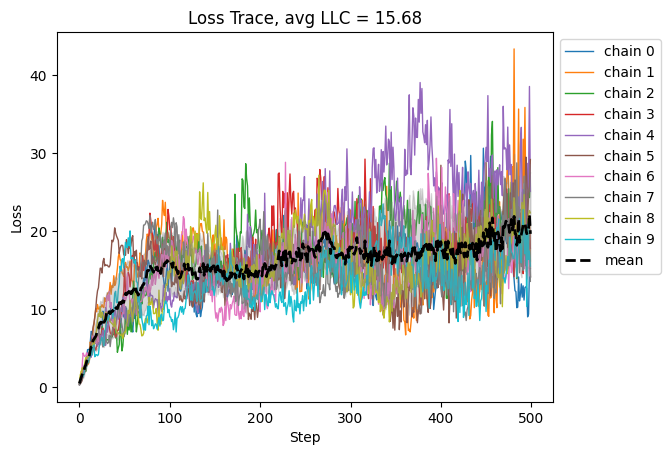

<Figure size 1200x900 with 0 Axes>

In [36]:
plot_trace(
    trace,
    "Loss",
    x_axis="Step",
    title=f"Loss Trace, avg LLC = {sum(learning_coeff_stats['llc/means']) / len(learning_coeff_stats['llc/means']):.2f}",
    plot_mean=False,
    plot_std=False,
    fig_size=(12, 9),
    true_lc=None,
)

In [39]:
model = check_fractok()
torch_model = haiku_to_pytorch(model).to(DEVICE)

# Print model structure
print(torch_model)

TracrTransformer(
  (layers): ModuleList(
    (0-1): 2 x TracrBlock(
      (attn): TracrAttention(
        (query): Linear(in_features=29, out_features=12, bias=True)
        (key): Linear(in_features=29, out_features=12, bias=True)
        (value): Linear(in_features=29, out_features=12, bias=True)
        (output): Linear(in_features=12, out_features=29, bias=True)
      )
      (mlp): TracrMLP(
        (linear1): Linear(in_features=29, out_features=1, bias=True)
        (linear2): Linear(in_features=1, out_features=29, bias=True)
      )
    )
  )
)


In [ ]:
#parameter counting and LLC estimation across configurations

import pandas as pd
from torchinfo import summary
import itertools

# Define experiment parameters
max_seq_lens = [10, 50]
vocab_ranges = ['small', 'medium', 'large']
num_trials = 5

# Storage for results
results = []

total_configs = len(max_seq_lens) * len(vocab_ranges)
config_num = 0

# Run all combinations
for max_seq_len, vocab_range in itertools.product(max_seq_lens, vocab_ranges):
    config_num += 1
    print(f"\n{'='*60}")
    print(f"Configuration {config_num}/{total_configs}: vocab={vocab_range}, max_seq_len={max_seq_len}")
    print(f"{'='*60}")
    
    # Create model and loader
    loader = makeFractokDataLoader(max_seq_len=max_seq_len, vocab_size=vocab_range)
    model = check_fractok(max_seq_len=max_seq_len, vocab_size=vocab_range)
    torch_model = haiku_to_pytorch(model).to(DEVICE)
    
    # Get model info
    model_summary = summary(torch_model, verbose=0)
    num_params = model_summary.total_params
    num_blocks = len([m for m in torch_model.modules() if 'block' in str(type(m)).lower()])
    
    print(f"Model: {num_params} params, {num_blocks} blocks")
    
    # Convert vocab_range to readable format
    if vocab_range == 'small':
        vocab_str = 'a-e'
    elif vocab_range == 'medium':
        vocab_str = 'a-m'
    elif vocab_range == 'large':
        vocab_str = 'a-z'
    
    # Run trials
    for trial in range(num_trials):
        print(f"  Trial {trial + 1}/{num_trials}...", end=" ", flush=True)
        
        learning_coeff_stats = estimate_learning_coeff_with_summary(
            torch_model,
            loader=loader,
            evaluate=evaluate,
            sampling_method=SGLD,
            optimizer_kwargs=dict(lr=1e-5, localization=1.0, nbeta=default_nbeta(loader)),
            num_chains=10,
            num_draws=100,
            num_burnin_steps=0,
            num_steps_bw_draws=1,
            device=DEVICE,
            online=True,
        )
        avg_llc = sum(learning_coeff_stats['llc/means']) / len(learning_coeff_stats['llc/means'])
        print(f"LLC = {avg_llc:.4f}")
        
        # Append one row per trial
        results.append({
            'Average LLC': round(avg_llc, 4),
            'num_blocks': num_blocks,
            'num_params': num_params,
            'vocab': vocab_str,
            'max_input_size': max_seq_len
        })

# Create and display table
print("\n" + "="*60)
print("FINAL RESULTS")
print("="*60)
df = pd.DataFrame(results)
df = df[['Average LLC', 'num_blocks', 'num_params', 'vocab', 'max_input_size']]

# Format to show 4 decimal places
pd.options.display.float_format = '{:.4f}'.format
print(df.to_string(index=False))

df.to_csv('fractok_results2.csv', index=False, float_format='%.4f')
print("\nSaved to fractok_results2.csv")


Configuration 1/6: vocab=small, max_seq_len=10
Model: 2258 params, 2 blocks
  Trial 1/5... 

Chain 9: 100%|██████████| 100/100 [00:00<00:00, 125.38it/s]

LLC = 8.2891
  Trial 2/5... 


Chain 9: 100%|██████████| 100/100 [00:00<00:00, 115.19it/s]

LLC = 8.7613
  Trial 3/5... 


Chain 9: 100%|██████████| 100/100 [00:00<00:00, 120.05it/s]

LLC = 8.4911
  Trial 4/5... 


Chain 9: 100%|██████████| 100/100 [00:00<00:00, 128.32it/s]

LLC = 8.3684
  Trial 5/5... 


Chain 9: 100%|██████████| 100/100 [00:00<00:00, 126.87it/s]


LLC = 8.1260

Configuration 2/6: vocab=medium, max_seq_len=10
Model: 3090 params, 2 blocks
  Trial 1/5... 

Chain 9: 100%|██████████| 100/100 [00:01<00:00, 91.22it/s]

LLC = 9.3642
  Trial 2/5... 


Chain 9: 100%|██████████| 100/100 [00:01<00:00, 99.67it/s]

LLC = 9.8553
  Trial 3/5... 


Chain 9: 100%|██████████| 100/100 [00:02<00:00, 39.74it/s]

LLC = 9.6194
  Trial 4/5... 


Chain 9: 100%|██████████| 100/100 [00:00<00:00, 100.56it/s]

LLC = 10.2361
  Trial 5/5... 


Chain 9: 100%|██████████| 100/100 [00:00<00:00, 100.36it/s]


LLC = 10.0912

Configuration 3/6: vocab=large, max_seq_len=10
Model: 4338 params, 2 blocks
  Trial 1/5... 

Chain 9: 100%|██████████| 100/100 [00:01<00:00, 81.17it/s]

LLC = 13.7571
  Trial 2/5... 


Chain 9: 100%|██████████| 100/100 [00:01<00:00, 91.60it/s]

LLC = 13.4389
  Trial 3/5... 


Chain 9: 100%|██████████| 100/100 [00:01<00:00, 91.73it/s]

LLC = 14.0991
  Trial 4/5... 


Chain 9: 100%|██████████| 100/100 [00:01<00:00, 90.66it/s]

LLC = 13.6398
  Trial 5/5... 


Chain 9: 100%|██████████| 100/100 [00:01<00:00, 90.02it/s]


LLC = 13.8341

Configuration 4/6: vocab=small, max_seq_len=50
Model: 26178 params, 2 blocks
  Trial 1/5... 

Chain 9: 100%|██████████| 100/100 [00:01<00:00, 95.18it/s]

LLC = 13.5015
  Trial 2/5... 


Chain 9: 100%|██████████| 100/100 [00:00<00:00, 101.89it/s]

LLC = 14.4288
  Trial 3/5... 


Chain 9: 100%|██████████| 100/100 [00:00<00:00, 102.46it/s]

LLC = 14.4603
  Trial 4/5... 


Chain 9: 100%|██████████| 100/100 [00:01<00:00, 95.89it/s]

LLC = 14.6600
  Trial 5/5... 


Chain 9: 100%|██████████| 100/100 [00:00<00:00, 102.69it/s]


LLC = 14.3807

Configuration 5/6: vocab=medium, max_seq_len=50
Model: 29570 params, 2 blocks
  Trial 1/5... 

Chain 9: 100%|██████████| 100/100 [00:00<00:00, 100.83it/s]

LLC = 13.5470
  Trial 2/5... 


Chain 9: 100%|██████████| 100/100 [00:00<00:00, 100.19it/s]

LLC = 15.0032
  Trial 3/5... 


Chain 9: 100%|██████████| 100/100 [00:01<00:00, 99.37it/s]

LLC = 13.9542
  Trial 4/5... 


Chain 9: 100%|██████████| 100/100 [00:00<00:00, 100.67it/s]

LLC = 15.1090
  Trial 5/5... 


Chain 9: 100%|██████████| 100/100 [00:00<00:00, 101.00it/s]


LLC = 15.2159

Configuration 6/6: vocab=large, max_seq_len=50
Model: 34658 params, 2 blocks
  Trial 1/5... 

Chain 9: 100%|██████████| 100/100 [00:01<00:00, 72.71it/s]

LLC = 16.3104
  Trial 2/5... 


Chain 9: 100%|██████████| 100/100 [00:01<00:00, 74.26it/s]

LLC = 15.5869
  Trial 3/5... 


Chain 9: 100%|██████████| 100/100 [00:01<00:00, 74.72it/s]

LLC = 15.8667
  Trial 4/5... 


Chain 9: 100%|██████████| 100/100 [00:01<00:00, 76.47it/s]

LLC = 16.0645
  Trial 5/5... 


Chain 9: 100%|██████████| 100/100 [00:01<00:00, 76.52it/s]

LLC = 15.1737

FINAL RESULTS
 Average LLC  num_blocks  num_params vocab  max_input_size
      8.2891           2        2258   a-e              10
      8.7613           2        2258   a-e              10
      8.4911           2        2258   a-e              10
      8.3684           2        2258   a-e              10
      8.1260           2        2258   a-e              10
      9.3642           2        3090   a-m              10
      9.8553           2        3090   a-m              10
      9.6194           2        3090   a-m              10
     10.2361           2        3090   a-m              10
     10.0912           2        3090   a-m              10
     13.7571           2        4338   a-z              10
     13.4389           2        4338   a-z              10
     14.0991           2        4338   a-z              10
     13.6398           2        4338   a-z              10
     13.8341           2        4338   a-z              10
     13.5015           2   

Creating baseline model and data loader...
Baseline model: 3090 parameters

Running 8 ablations × 3 trials = 24 total

Ablation 1/8: Full model (baseline)
  Trial 1/3... 

/Users/meerigupta/Downloads/llc-interpretability/venv/lib/python3.12/site-packages/devinterp/utils.py:88: UserWarning: default nbeta is undefined for batch_size * grad_accum_steps == 1, falling back to default value of 1
  warnings.warn(
/Users/meerigupta/Downloads/llc-interpretability/venv/lib/python3.12/site-packages/devinterp/slt/sampler.py:117: UserWarning: Using passed in nbeta. Make sure callbacks are also initialized with the same nbeta.
  warnings.warn(
/Users/meerigupta/Downloads/llc-interpretability/venv/lib/python3.12/site-packages/devinterp/backends/default/slt/sampler.py:240: UserWarning: You are taking more draws than burn-in steps, your LLC estimates will likely be underestimates. Please check LLC chain convergence.
  warnings.warn(
/Users/meerigupta/Downloads/llc-interpretability/venv/lib/python3.12/site-packages/devinterp/backends/default/slt/sampler.py:285: UserWarning: If you're setting a nbeta or temperature in optimizer_kwargs, please also make sure to set it in th

LLC = 26.3670
  Trial 2/3... 


Chain 9: 100%|██████████| 120/120 [00:01<00:00, 102.76it/s]

LLC = 26.1580
  Trial 3/3... 


Chain 9: 100%|██████████| 120/120 [00:01<00:00, 102.45it/s]

LLC = 27.6009
Ablation 2/8: Remove layer 0
  Trial 1/3... 


Chain 9: 100%|██████████| 120/120 [00:01<00:00, 100.52it/s]

LLC = 25.1007
  Trial 2/3... 


Chain 9: 100%|██████████| 120/120 [00:01<00:00, 101.38it/s]

LLC = 25.1871
  Trial 3/3... 


Chain 9: 100%|██████████| 120/120 [00:01<00:00, 95.92it/s]

LLC = 25.5037
Ablation 3/8: Remove layer 1
  Trial 1/3... 


Chain 9: 100%|██████████| 120/120 [00:01<00:00, 95.14it/s] 

LLC = 17.2555
  Trial 2/3... 


Chain 9: 100%|██████████| 120/120 [00:01<00:00, 100.06it/s]

LLC = 16.8352
  Trial 3/3... 


Chain 9: 100%|██████████| 120/120 [00:01<00:00, 106.28it/s]

LLC = 16.8805
Ablation 4/8: No attention in layer 0
  Trial 1/3... 


Chain 9: 100%|██████████| 120/120 [00:01<00:00, 99.04it/s]

LLC = 25.4497
  Trial 2/3... 


Chain 9: 100%|██████████| 120/120 [00:01<00:00, 104.09it/s]

LLC = 26.5032
  Trial 3/3... 


Chain 9: 100%|██████████| 120/120 [00:01<00:00, 103.53it/s]

LLC = 24.8302
Ablation 5/8: No attention in layer 1
  Trial 1/3... 


Chain 9: 100%|██████████| 120/120 [00:01<00:00, 79.71it/s]

LLC = 17.3707
  Trial 2/3... 


Chain 9: 100%|██████████| 120/120 [00:01<00:00, 100.28it/s]

LLC = 18.1758
  Trial 3/3... 


Chain 9: 100%|██████████| 120/120 [00:01<00:00, 103.28it/s]

LLC = 17.7640
Ablation 6/8: No MLP in layer 0
  Trial 1/3... 


Chain 9: 100%|██████████| 120/120 [00:01<00:00, 101.72it/s]

LLC = 26.6955
  Trial 2/3... 


Chain 9: 100%|██████████| 120/120 [00:01<00:00, 101.63it/s]

LLC = 26.1868
  Trial 3/3... 


Chain 9: 100%|██████████| 120/120 [00:01<00:00, 89.65it/s]

LLC = 25.7970
Ablation 7/8: No MLP in layer 1
  Trial 1/3... 


Chain 9: 100%|██████████| 120/120 [00:01<00:00, 90.41it/s] 

LLC = 26.7024
  Trial 2/3... 


Chain 9: 100%|██████████| 120/120 [00:01<00:00, 100.64it/s]

LLC = 25.8706
  Trial 3/3... 


Chain 9: 100%|██████████| 120/120 [00:01<00:00, 101.12it/s]

LLC = 25.8601
Ablation 8/8: Remove both layers
  Trial 1/3... 


Chain 0:   0%|          | 0/120 [00:00<?, ?it/s]

ERROR: element 0 of tensors does not require grad and does not have a grad_fn
  Trial 2/3... 


Chain 0:   0%|          | 0/120 [00:00<?, ?it/s]

ERROR: element 0 of tensors does not require grad and does not have a grad_fn
  Trial 3/3... 


Chain 0:   0%|          | 0/120 [00:00<?, ?it/s]


ERROR: element 0 of tensors does not require grad and does not have a grad_fn

FINAL RESULTS

Summary Statistics:
  ablation             description  llc_mean  llc_std  num_trials
full_model   Full model (baseline)   26.7086   0.7798           3
no_attn_L0 No attention in layer 0   25.5944   0.8458           3
no_attn_L1 No attention in layer 1   17.7702   0.4026           3
no_layer_0          Remove layer 0   25.2638   0.2122           3
no_layer_1          Remove layer 1   16.9904   0.2307           3
 no_layers      Remove both layers       NaN      NaN           0
 no_mlp_L0       No MLP in layer 0   26.2264   0.4506           3
 no_mlp_L1       No MLP in layer 1   26.1444   0.4833           3

Detailed results saved to: ablation_results_detailed.csv
Summary results saved to: ablation_results_summary.csv
Plot saved to: ablation_results.png


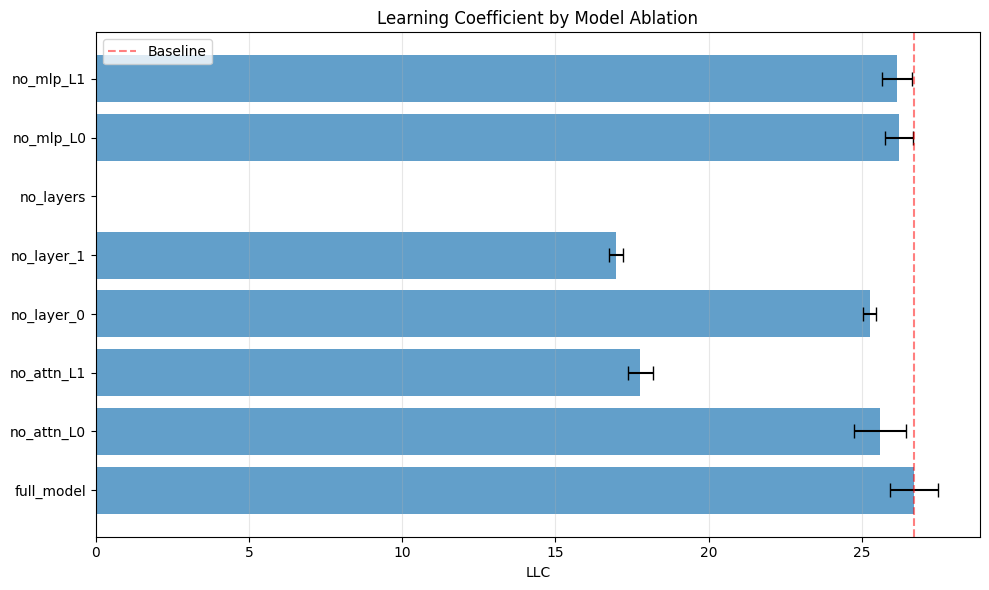


ABLATION STUDY COMPLETE!


In [ ]:
#Full ablation code

import pandas as pd
import copy
from torchinfo import summary

# Ablation functions
def ablate_layer(model, layer_idx):
    """Remove a specific layer by making it return identity"""
    def identity_forward(x):
        return x
    model.layers[layer_idx].forward = identity_forward
    return model

def ablate_attention(model, layer_idx):
    """Zero out attention in a specific layer"""
    # def attn_zero(self, x):
    #     return torch.zeros_like(x)
    # Replace the forward method
    # original_forward = model.layers[layer_idx].attn.forward
    model.layers[layer_idx].attn.forward = lambda x: torch.zeros_like(x)
    return model

def ablate_mlp(model, layer_idx):
    """Zero out MLP in a specific layer"""
    model.layers[layer_idx].mlp.forward = lambda x: torch.zeros_like(x)
    return model

# Define ablations to test
ablations = [
    {'name': 'full_model', 'description': 'Full model (baseline)', 'fn': None},
    {'name': 'no_layer_0', 'description': 'Remove layer 0', 'fn': lambda m: ablate_layer(m, 0)},
    {'name': 'no_layer_1', 'description': 'Remove layer 1', 'fn': lambda m: ablate_layer(m, 1)},
    {'name': 'no_attn_L0', 'description': 'No attention in layer 0', 'fn': lambda m: ablate_attention(m, 0)},
    {'name': 'no_attn_L1', 'description': 'No attention in layer 1', 'fn': lambda m: ablate_attention(m, 1)},
    {'name': 'no_mlp_L0', 'description': 'No MLP in layer 0', 'fn': lambda m: ablate_mlp(m, 0)},
    {'name': 'no_mlp_L1', 'description': 'No MLP in layer 1', 'fn': lambda m: ablate_mlp(m, 1)},
    {'name': 'no_layers', 'description': 'Remove both layers', 'fn': lambda m: ablate_layer(ablate_layer(m, 0), 1)},
]

# Experiment parameters
num_trials = 3  # Trials per ablation
max_seq_len = 10  # Use your default
vocab_range = 'medium'  # Use your default

# Storage for results
results = []

# Create baseline model and loader once
print("Creating baseline model and data loader...")
loader = makeFractokDataLoader(max_seq_len=max_seq_len, vocab_size=vocab_range)
base_model = check_fractok(max_seq_len=max_seq_len, vocab_size=vocab_range)
base_torch_model = haiku_to_pytorch(base_model).to(DEVICE)

# Get baseline model info
model_summary = summary(base_torch_model, verbose=0)
num_params = model_summary.total_params

print(f"Baseline model: {num_params} parameters")
print(f"\nRunning {len(ablations)} ablations × {num_trials} trials = {len(ablations) * num_trials} total\n")

# Run ablations
for ablation_idx, ablation in enumerate(ablations):
    ablation_name = ablation['name']
    ablation_desc = ablation['description']
    ablation_fn = ablation['fn']
    
    print(f"{'='*60}")
    print(f"Ablation {ablation_idx + 1}/{len(ablations)}: {ablation_desc}")
    print(f"{'='*60}")
    
    # Run trials
    for trial in range(num_trials):
        print(f"  Trial {trial + 1}/{num_trials}...", end=" ", flush=True)
        
        # Create fresh copy of model for this trial
        torch_model = copy.deepcopy(base_torch_model)
        
        # Apply ablation (if not baseline)
        if ablation_fn is not None:
            torch_model = ablation_fn(torch_model)
        
        # Estimate LLC
        try:
            learning_coeff_stats = estimate_learning_coeff_with_summary(
                torch_model,
                loader=loader,
                evaluate=evaluate,
                sampling_method=SGLD,
                optimizer_kwargs=dict(lr=1e-4, localization=1.0, nbeta=default_nbeta(loader)),
                num_chains=10,
                num_draws=100,
                num_burnin_steps=20,
                num_steps_bw_draws=1,
                device=DEVICE,
                online=True,
            )
            avg_llc = sum(learning_coeff_stats['llc/means']) / len(learning_coeff_stats['llc/means'])
            print(f"LLC = {avg_llc:.4f}")
            
            # Store results
            results.append({
                'ablation': ablation_name,
                'description': ablation_desc,
                'trial': trial + 1,
                'llc': round(avg_llc, 4),
                'num_params': num_params,
                'max_seq_len': max_seq_len,
                'vocab_range': vocab_range,
            })
        except Exception as e:
            print(f"ERROR: {e}")
            results.append({
                'ablation': ablation_name,
                'description': ablation_desc,
                'trial': trial + 1,
                'llc': None,
                'num_params': num_params,
                'max_seq_len': max_seq_len,
                'vocab_range': vocab_range,
            })

# Create DataFrame
print("\n" + "="*60)
print("FINAL RESULTS")
print("="*60)
df = pd.DataFrame(results)

# Calculate statistics per ablation
summary_df = df.groupby(['ablation', 'description']).agg({
    'llc': ['mean', 'std', 'count']
}).reset_index()
summary_df.columns = ['ablation', 'description', 'llc_mean', 'llc_std', 'num_trials']
summary_df = summary_df.round(4)

print("\nSummary Statistics:")
print(summary_df.to_string(index=False))

# Save detailed results
df.to_csv('ablation_results_detailed.csv', index=False, float_format='%.4f')
print("\nDetailed results saved to: ablation_results_detailed.csv")

# Save summary
summary_df.to_csv('ablation_results_summary.csv', index=False, float_format='%.4f')
print("Summary results saved to: ablation_results_summary.csv")

# Create visualization
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))

# Plot with error bars
ablation_names = summary_df['ablation']
llc_means = summary_df['llc_mean']
llc_stds = summary_df['llc_std']

y_pos = range(len(ablation_names))
ax.barh(y_pos, llc_means, xerr=llc_stds, capsize=5, alpha=0.7)
ax.set_yticks(y_pos)
ax.set_yticklabels(ablation_names)
ax.set_xlabel('LLC')
ax.set_title('Learning Coefficient by Model Ablation')
ax.axvline(x=llc_means.iloc[0], color='r', linestyle='--', alpha=0.5, label='Baseline')
ax.legend()
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('ablation_results.png', dpi=300, bbox_inches='tight')
print("Plot saved to: ablation_results.png")
plt.show()

print("\n" + "="*60)
print("ABLATION STUDY COMPLETE!")
print("="*60)

In [41]:
%pip install torchviz graphviz

/Users/meerigupta/miniforge3/lib/python3.12/pty.py:95: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [torchviz]
Note: you may need to restart the kernel to use updated packages.


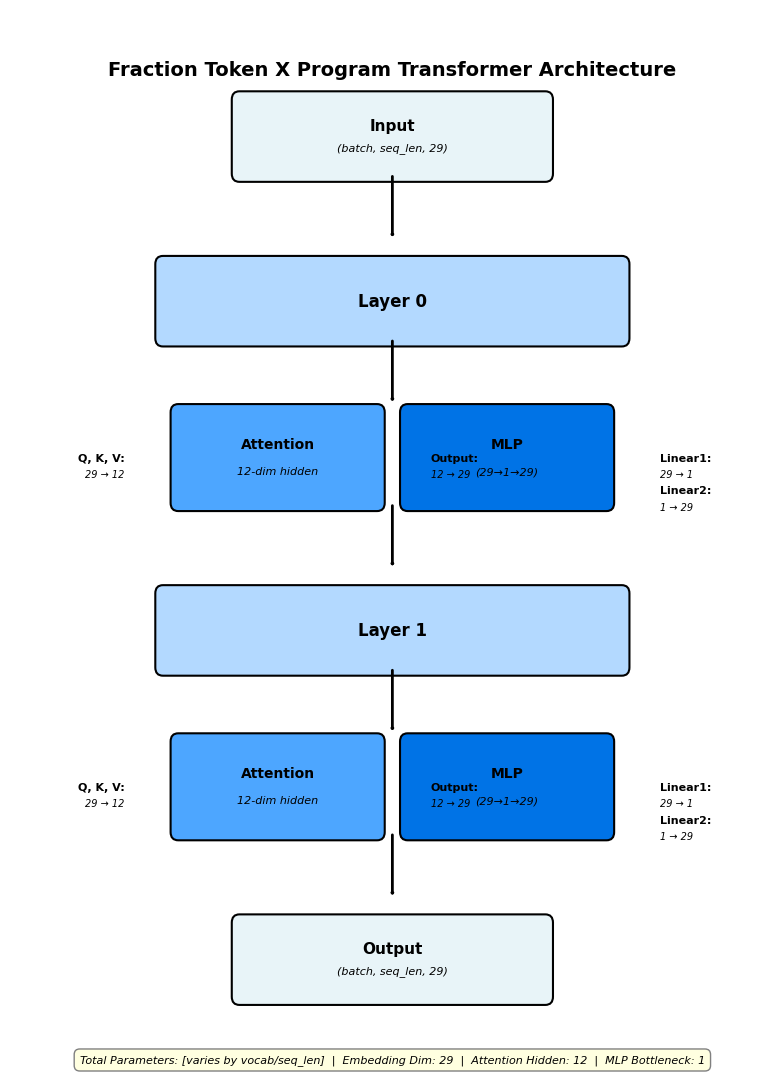

✓ Saved: model_architecture_detailed.png


In [ ]:
#for visualizing model architecture

import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch, FancyArrowPatch

fig, ax = plt.subplots(figsize=(8, 11))
ax.set_xlim(0, 10)
ax.set_ylim(0, 13)
ax.axis('off')

# Colors
color_input = '#e8f4f8'
color_layer = '#b3d9ff'
color_attn = '#4da6ff'
color_mlp = '#0073e6'

def add_box(ax, x, y, width, height, main_text, sub_text=None, color='white', fontsize=11, sub_fontsize=9):
    box = FancyBboxPatch(
        (x, y), width, height,
        boxstyle="round,pad=0.1",
        facecolor=color,
        edgecolor='black',
        linewidth=1.5
    )
    ax.add_patch(box)
    
    # Position text based on whether there's sub_text
    if sub_text:
        main_y = y + height*0.65
        sub_y = y + height*0.35
        ax.text(x + width/2, main_y, main_text,
                ha='center', va='center',
                fontsize=fontsize, weight='bold')
        ax.text(x + width/2, sub_y, sub_text,
                ha='center', va='center',
                fontsize=sub_fontsize, style='italic')
    else:
        ax.text(x + width/2, y + height/2, main_text,
                ha='center', va='center',
                fontsize=fontsize, weight='bold')

def add_arrow(ax, x1, y1, x2, y2):
    arrow = FancyArrowPatch(
        (x1, y1), (x2, y2),
        arrowstyle='->,head_width=0.4,head_length=0.4',
        color='black',
        linewidth=2
    )
    ax.add_patch(arrow)

# Input
add_box(ax, 3, 11.0, 4, 0.9, 'Input', '(batch, seq_len, 29)', color_input, 11, 8)
add_arrow(ax, 5, 11.0, 5, 10.2)

# Layer 0 Header
add_box(ax, 2, 9.0, 6, 0.9, 'Layer 0', color=color_layer, fontsize=12)
add_arrow(ax, 5, 9.0, 5, 8.2)

# Layer 0 - Attention
add_box(ax, 2.2, 7.0, 2.6, 1.1, 'Attention', '12-dim hidden', color_attn, 10, 8)
ax.text(1.5, 7.55, 'Q, K, V:', fontsize=8, ha='right', va='center', weight='bold')
ax.text(1.5, 7.35, '29 → 12', fontsize=7, ha='right', va='center', style='italic')
ax.text(5.5, 7.55, 'Output:', fontsize=8, ha='left', va='center', weight='bold')
ax.text(5.5, 7.35, '12 → 29', fontsize=7, ha='left', va='center', style='italic')

# Layer 0 - MLP  
add_box(ax, 5.2, 7.0, 2.6, 1.1, 'MLP', '(29→1→29)', color_mlp, 10, 8)
ax.text(8.5, 7.55, 'Linear1:', fontsize=8, ha='left', va='center', weight='bold')
ax.text(8.5, 7.35, '29 → 1', fontsize=7, ha='left', va='center', style='italic')
ax.text(8.5, 7.15, 'Linear2:', fontsize=8, ha='left', va='center', weight='bold')
ax.text(8.5, 6.95, '1 → 29', fontsize=7, ha='left', va='center', style='italic')

add_arrow(ax, 5, 7.0, 5, 6.2)

# Layer 1 Header
add_box(ax, 2, 5.0, 6, 0.9, 'Layer 1', color=color_layer, fontsize=12)
add_arrow(ax, 5, 5.0, 5, 4.2)

# Layer 1 - Attention
add_box(ax, 2.2, 3.0, 2.6, 1.1, 'Attention', '12-dim hidden', color_attn, 10, 8)
ax.text(1.5, 3.55, 'Q, K, V:', fontsize=8, ha='right', va='center', weight='bold')
ax.text(1.5, 3.35, '29 → 12', fontsize=7, ha='right', va='center', style='italic')
ax.text(5.5, 3.55, 'Output:', fontsize=8, ha='left', va='center', weight='bold')
ax.text(5.5, 3.35, '12 → 29', fontsize=7, ha='left', va='center', style='italic')

# Layer 1 - MLP
add_box(ax, 5.2, 3.0, 2.6, 1.1, 'MLP', '(29→1→29)', color_mlp, 10, 8)
ax.text(8.5, 3.55, 'Linear1:', fontsize=8, ha='left', va='center', weight='bold')
ax.text(8.5, 3.35, '29 → 1', fontsize=7, ha='left', va='center', style='italic')
ax.text(8.5, 3.15, 'Linear2:', fontsize=8, ha='left', va='center', weight='bold')
ax.text(8.5, 2.95, '1 → 29', fontsize=7, ha='left', va='center', style='italic')

add_arrow(ax, 5, 3.0, 5, 2.2)

# Output
add_box(ax, 3, 1.0, 4, 0.9, 'Output', '(batch, seq_len, 29)', color_input, 11, 8)

# Title
ax.text(5, 12.2, 'Fraction Token X Program Transformer Architecture', 
        ha='center', fontsize=14, weight='bold')

# Add parameter info box
info_box_y = 0.2
ax.text(5, info_box_y, 'Total Parameters: [varies by vocab/seq_len]  |  Embedding Dim: 29  |  Attention Hidden: 12  |  MLP Bottleneck: 1',
        ha='center', fontsize=8, style='italic', 
        bbox=dict(boxstyle='round,pad=0.5', facecolor='lightyellow', edgecolor='gray', linewidth=1))

plt.tight_layout()
plt.savefig('model_architecture_detailed.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()
print("✓ Saved: model_architecture_detailed.png")

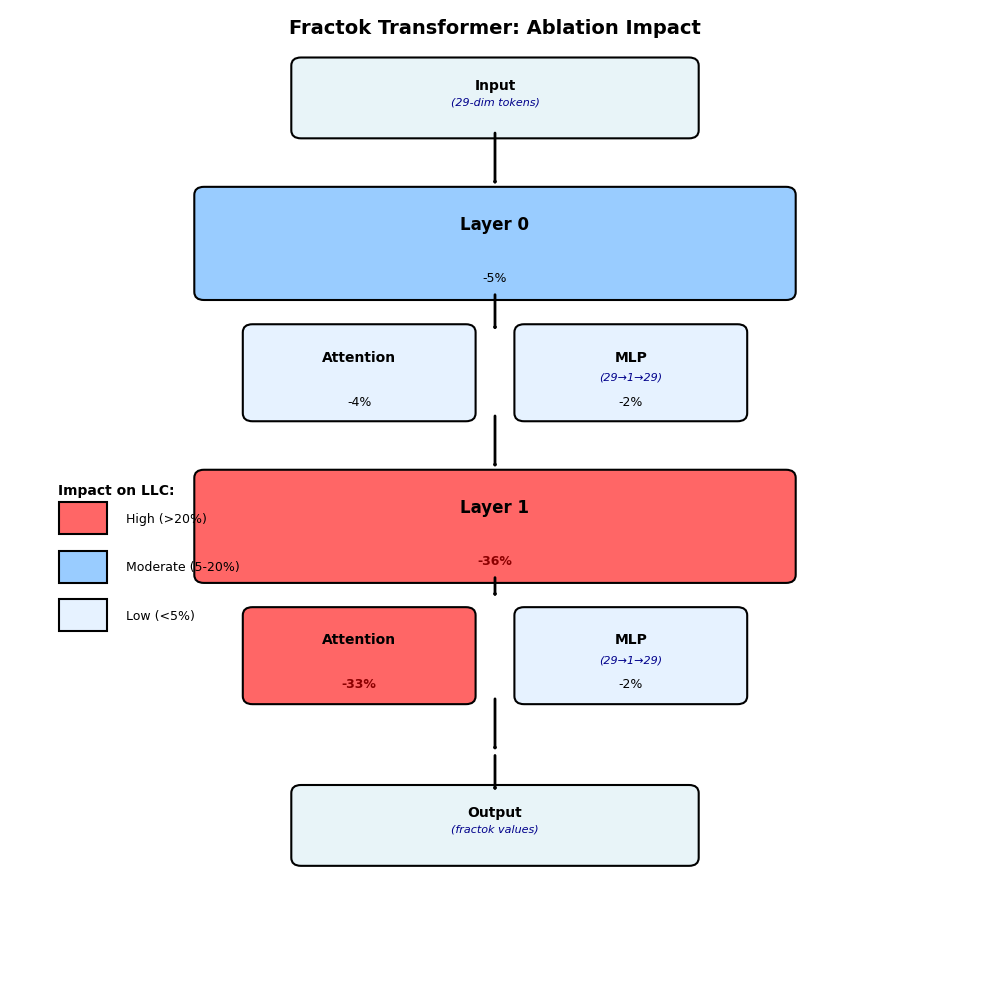

✓ Saved: model_architecture_annotated.png


In [ ]:
#for annotated ablation impact diagram

import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch, FancyArrowPatch
import matplotlib.patches as mpatches

fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlim(0, 10)
ax.set_ylim(0, 12)
ax.axis('off')

# Ablation results
ablation_results = {
    'Layer 0': -5,
    'Layer 1': -36,
    'Attn L0': -4,
    'Attn L1': -33,
    'MLP L0': -2,
    'MLP L1': -2,
}

def get_color(impact):
    if impact is None:
        return '#e8f4f8'
    if abs(impact) < 5:
        return '#e6f2ff'
    elif abs(impact) < 20:
        return '#99ccff'
    else:
        return '#ff6666'

def add_box(ax, x, y, width, height, main_text, sub_text=None, impact=None, fontsize=11):
    color = get_color(impact)
    
    box = FancyBboxPatch(
        (x, y), width, height,
        boxstyle="round,pad=0.1",
        facecolor=color,
        edgecolor='black',
        linewidth=1.5
    )
    ax.add_patch(box)
    
    # Main text position
    text_y = y + height*0.7 if sub_text or impact is not None else y + height/2
    ax.text(x + width/2, text_y, main_text,
            ha='center', va='center',
            fontsize=fontsize, weight='bold')
    
    # Sub text (like "29→1→29") - smaller, below main
    if sub_text:
        ax.text(x + width/2, y + height*0.45, sub_text,
                ha='center', va='center',
                fontsize=8, style='italic', color='darkblue')
    
    # Impact percentage - at bottom
    if impact is not None:
        impact_color = 'darkred' if abs(impact) > 20 else 'black'
        ax.text(x + width/2, y + height*0.15, f'{impact:+d}%',
                ha='center', va='center',
                fontsize=9, weight='bold' if abs(impact) > 20 else 'normal',
                color=impact_color)

def add_arrow(ax, x1, y1, x2, y2):
    arrow = FancyArrowPatch(
        (x1, y1), (x2, y2),
        arrowstyle='->,head_width=0.4,head_length=0.4',
        color='black',
        linewidth=2
    )
    ax.add_patch(arrow)

# Input
add_box(ax, 3, 10.5, 4, 0.8, 'Input', '(29-dim tokens)', fontsize=10)
add_arrow(ax, 5, 10.5, 5, 9.8)

# Layer 0
add_box(ax, 2, 8.5, 6, 1.2, 'Layer 0', impact=ablation_results['Layer 0'], fontsize=12)
add_box(ax, 2.5, 7.0, 2.2, 1.0, 'Attention', impact=ablation_results['Attn L0'], fontsize=10)
add_box(ax, 5.3, 7.0, 2.2, 1.0, 'MLP', '(29→1→29)', ablation_results['MLP L0'], fontsize=10)
add_arrow(ax, 5, 8.5, 5, 8.0)
add_arrow(ax, 5, 7.0, 5, 6.3)

# Layer 1  
add_box(ax, 2, 5.0, 6, 1.2, 'Layer 1', impact=ablation_results['Layer 1'], fontsize=12)
add_box(ax, 2.5, 3.5, 2.2, 1.0, 'Attention', impact=ablation_results['Attn L1'], fontsize=10)
add_box(ax, 5.3, 3.5, 2.2, 1.0, 'MLP', '(29→1→29)', ablation_results['MLP L1'], fontsize=10)
add_arrow(ax, 5, 5.0, 5, 4.7)
add_arrow(ax, 5, 3.5, 5, 2.8)

# Output
add_box(ax, 3, 1.5, 4, 0.8, 'Output', '(fractok values)', fontsize=10)
add_arrow(ax, 5, 2.8, 5, 2.3)

# Title
ax.text(5, 11.7, 'Fraction Token Transformer: Ablation Impact', 
        ha='center', fontsize=14, weight='bold')

# Legend
legend_x = 0.5
legend_y = 5.5
ax.text(legend_x, legend_y + 0.5, 'Impact on LLC:', fontsize=10, weight='bold')

ax.add_patch(mpatches.Rectangle((legend_x, legend_y), 0.5, 0.4, 
                                facecolor='#ff6666', edgecolor='black', linewidth=1.5))
ax.text(legend_x + 0.7, legend_y + 0.2, 'High (>20%)', fontsize=9, va='center')

ax.add_patch(mpatches.Rectangle((legend_x, legend_y - 0.6), 0.5, 0.4, 
                                facecolor='#99ccff', edgecolor='black', linewidth=1.5))
ax.text(legend_x + 0.7, legend_y - 0.4, 'Moderate (5-20%)', fontsize=9, va='center')

ax.add_patch(mpatches.Rectangle((legend_x, legend_y - 1.2), 0.5, 0.4, 
                                facecolor='#e6f2ff', edgecolor='black', linewidth=1.5))
ax.text(legend_x + 0.7, legend_y - 1.0, 'Low (<5%)', fontsize=9, va='center')

plt.tight_layout()
plt.savefig('model_architecture_annotated.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()
print("✓ Saved: model_architecture_annotated.png")

In [ ]:
#for compiling ablation results into a formatted table

import pandas as pd
import numpy as np

# Load  detailed results
df = pd.read_csv('ablation_results_detailed.csv')

# Calculate summary statistics per ablation
summary = df.groupby('ablation').agg({
    'llc': ['mean', 'std']
}).reset_index()

summary.columns = ['ablation', 'llc_mean', 'llc_std']

# Get baseline LLC
baseline_llc = summary[summary['ablation'] == 'full_model']['llc_mean'].values[0]

# Calculate delta and percent change
summary['delta'] = summary['llc_mean'] - baseline_llc
summary['percent_change'] = (summary['delta'] / baseline_llc * 100).round(0)

# Format for display
summary['LLC'] = summary['llc_mean'].round(1)
summary['Δ from Baseline'] = summary['delta'].round(1)

# Format percent change, handling NaN
summary['% Change'] = summary['percent_change'].apply(
    lambda x: f"{int(x)}%" if pd.notna(x) else "N/A"
)

# Replace baseline values with dashes
summary.loc[summary['ablation'] == 'full_model', 'Δ from Baseline'] = '—'
summary.loc[summary['ablation'] == 'full_model', '% Change'] = '—'

# Rename ablations to more readable names
ablation_names = {
    'full_model': 'Full Model',
    'no_mlp_L0': 'No MLP L0',
    'no_mlp_L1': 'No MLP L1',
    'no_attn_L0': 'No Attn L0',
    'no_layer_0': 'No Layer 0',
    'no_attn_L1': 'No Attn L1',
    'no_layer_1': 'No Layer 1',
    'no_layers': 'No Layers'
}
summary['Component'] = summary['ablation'].map(ablation_names)

# Select and reorder columns
table = summary[['Component', 'LLC', 'Δ from Baseline', '% Change']]

# Sort by LLC (descending), putting NaN at the end
table = table.sort_values('LLC', ascending=False, na_position='last').reset_index(drop=True)

# Display
print("\n" + "="*60)
print("ABLATION RESULTS TABLE")
print("="*60)
print(table.to_string(index=False))
print("="*60)

# Save to CSV
table.to_csv('ablation_table_formatted.csv', index=False)
print("\n✓ Saved to: ablation_table_formatted.csv")

# Create markdown format
print("\n" + "="*60)
print("MARKDOWN FORMAT (for copy-paste)")
print("="*60)
print(table.to_markdown(index=False))


ABLATION RESULTS TABLE
 Component     LLC Δ from Baseline % Change
Full Model 26.7000               —        —
 No MLP L0 26.2000         -0.5000      -2%
 No MLP L1 26.1000         -0.6000      -2%
No Attn L0 25.6000         -1.1000      -4%
No Layer 0 25.3000         -1.4000      -5%
No Attn L1 17.8000         -8.9000     -33%
No Layer 1 17.0000         -9.7000     -36%
 No Layers     NaN             NaN      N/A

✓ Saved to: ablation_table_formatted.csv

MARKDOWN FORMAT (for copy-paste)
| Component   |   LLC | Δ from Baseline   | % Change   |
|:------------|------:|:------------------|:-----------|
| Full Model  |  26.7 | —                 | —          |
| No MLP L0   |  26.2 | -0.5              | -2%        |
| No MLP L1   |  26.1 | -0.6              | -2%        |
| No Attn L0  |  25.6 | -1.1              | -4%        |
| No Layer 0  |  25.3 | -1.4              | -5%        |
| No Attn L1  |  17.8 | -8.9              | -33%       |
| No Layer 1  |  17   | -9.7              | -36%

/var/folders/55/dm6h20w57jjbt4p27m13lx5w0000gn/T/ipykernel_78241/1898611955.py:31: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '—' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  summary.loc[summary['ablation'] == 'full_model', 'Δ from Baseline'] = '—'
